In [35]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class CustomTaxiEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, render_mode="rgb_array"):
        self.size = 6
        self.render_mode = render_mode

        self.observation_space = spaces.Dict({
            "taxi": spaces.MultiDiscrete([6, 6]),
            "passenger": spaces.MultiDiscrete([6, 6]),
            "destination": spaces.MultiDiscrete([6, 6]),
            "passenger_in_taxi": spaces.Discrete(2)
        })
        self.action_space = spaces.Discrete(6)

        self.forbidden = {(1,1), (3,5), (4,3)}

        self.walls = {
            frozenset(((1,3),(1,4))),
            frozenset(((2,3),(2,4))),

            frozenset(((4,1),(5,1))),
            frozenset(((4,1),(4,2))),
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        valid = [(r,c) for r in range(6) for c in range(6) if (r,c) not in self.forbidden]
        pos = self.np_random.choice(len(valid), 3, replace=False)
        chosen = [valid[i] for i in pos]
        self.taxi = np.array(chosen[0], dtype=np.int8)
        self.passenger = np.array(chosen[1], dtype=np.int8)
        self.destination = np.array(chosen[2], dtype=np.int8)
        self.passenger_in_taxi = False
        return self._get_obs(), {"action_mask": self._get_action_mask()}

    def _get_obs(self):
        return {
            "taxi": self.taxi.copy(),
            "passenger": self.passenger.copy(),
            "destination": self.destination.copy(),
            "passenger_in_taxi": int(self.passenger_in_taxi)
        }

    def _has_wall_between(self, pos1, pos2):
        p1 = (int(pos1[0]), int(pos1[1]))
        p2 = (int(pos2[0]), int(pos2[1]))
        return frozenset((p1, p2)) in self.walls

    def _is_valid_move(self, from_pos, to_pos):
        r, c = to_pos
        if not (0 <= r < 6 and 0 <= c < 6):
            return False
        if tuple(to_pos) in self.forbidden:
            return False
        # Duvar kontrolü
        if self._has_wall_between(from_pos, to_pos):
            return False
        return True

    def _get_action_mask(self):
        mask = np.zeros(6, dtype=np.int8)
        r, c = self.taxi

        # 4 yön: yukarı, aşağı, sol, sağ
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        for i, (dr, dc) in enumerate(directions):
            new_pos = (r + dr, c + dc)
            if self._is_valid_move(self.taxi, new_pos):
                mask[i] = 1

        # Pickup
        if not self.passenger_in_taxi and np.array_equal(self.taxi, self.passenger):
            mask[4] = 1

        # Dropoff
        if self.passenger_in_taxi and np.array_equal(self.taxi, self.destination):
            mask[5] = 1

        return mask

    def step(self, action):
        reward = -1
        terminated = False

        if action < 4:
            directions = [(-1,0), (1,0), (0,-1), (0,1)]
            dr, dc = directions[action]
            new_pos = (self.taxi[0] + dr, self.taxi[1] + dc)

            # Duvar/Sınır kontrolü
            if self._is_valid_move(self.taxi, new_pos):
                self.taxi[0] = new_pos[0]
                self.taxi[1] = new_pos[1]
            else:
                reward = -10

        # Pickup
        elif action == 4:
            if not self.passenger_in_taxi and np.array_equal(self.taxi, self.passenger):
                self.passenger_in_taxi = True
            else:
                reward = -10

        # Dropoff
        elif action == 5:
            if self.passenger_in_taxi and np.array_equal(self.taxi, self.destination):
                terminated = True
                reward = 20
            else:
                reward = -10

        return self._get_obs(), reward, terminated, False, {"action_mask": self._get_action_mask()}

    def render(self):
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = fig.add_axes([0,0,1,1])
        ax.set_xlim(0,6); ax.set_ylim(0,6)
        ax.set_aspect('equal'); ax.axis('off')


        for i in range(7):
            ax.axhline(i, color='lightgray', lw=0.8)
            ax.axvline(i, color='lightgray', lw=0.8)


        for r,c in self.forbidden:
            ax.add_patch(patches.Rectangle((c, 5-r), 1, 1, facecolor="#555555", edgecolor="black", lw=2))


        for wall in self.walls:
            p1, p2 = list(wall)
            (r1, c1), (r2, c2) = p1, p2


            if r1 > r2 or c1 > c2:
                (r1, c1), (r2, c2) = (r2, c2), (r1, c1)


            if r1 == r2:
                x = c2
                y_bot = 5 - r1
                y_top = 5 - r1 + 1
                ax.plot([x, x], [y_bot, y_top], color="black", linewidth=12, solid_capstyle='round')


            else:
                y = 5 - r1
                x_left = c1
                x_right = c1 + 1
                ax.plot([x_left, x_right], [y, y], color="black", linewidth=12, solid_capstyle='round')

        # Hedef (yeşil)
        dr, dc = self.destination
        ax.add_patch(patches.Rectangle((dc, 5-dr), 1, 1, facecolor="lightgreen", edgecolor="green", lw=4))

        # Yolcu
        if not self.passenger_in_taxi:
            pr, pc = self.passenger
            ax.add_patch(patches.Rectangle((pc, 5-pr), 1, 1, facecolor="skyblue", edgecolor="blue", lw=4))

        # Taksi
        tr, tc = self.taxi
        ax.add_patch(patches.Rectangle((tc, 5-tr), 1, 1, facecolor="gold", edgecolor="orange", lw=4))
        if self.passenger_in_taxi:
            ax.text(tc+0.5, 5-tr+0.5, "P", fontsize=26, fontweight='bold',
                    ha='center', va='center', color="mediumblue")

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
        plt.close(fig)
        return img

def create_custom_env():
    return CustomTaxiEnv(render_mode="rgb_array")

State space: Dict('destination': MultiDiscrete([6 6]), 'passenger': MultiDiscrete([6 6]), 'passenger_in_taxi': Discrete(2), 'taxi': MultiDiscrete([6 6]))
Action space: Discrete(6)
Action mask (Step): [1 0 1 1 0 0]
State: {'taxi': array([3, 4], dtype=int8), 'passenger': array([0, 2], dtype=int8), 'destination': array([4, 2], dtype=int8), 'passenger_in_taxi': 0}
Action: 2
Reward: -1
Terminated: False
Truncated: False


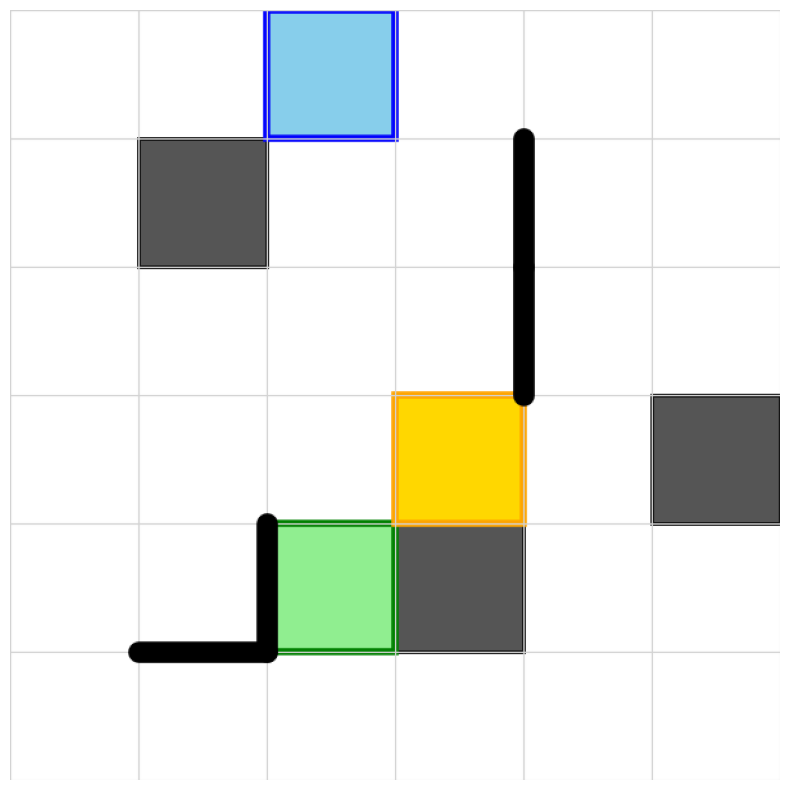

In [36]:
env = create_custom_env()
state, info = env.reset(seed=42)
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")

action = np.random.choice(np.where(info['action_mask'] == 1)[0])
next_state, reward, terminated, truncated, info = env.step(action)

print("Action mask (Step): {}".format(info['action_mask']))
print("State: {}".format(state))
print("Action: {}".format(action))
print("Reward: {}".format(reward))
print("Terminated:", terminated)
print("Truncated:", truncated)

frame = env.render()
plt.figure(figsize=(10,10))
plt.imshow(frame)
plt.axis("off")
plt.show()

In [37]:
def state_to_index(state_dict):
    # Değerleri numpy dizisinden çıkarıp standart int'e çeviriyoruz
    tr, tc = int(state_dict['taxi'][0]), int(state_dict['taxi'][1])
    pr, pc = int(state_dict['passenger'][0]), int(state_dict['passenger'][1])
    dr, dc = int(state_dict['destination'][0]), int(state_dict['destination'][1])
    in_taxi = int(state_dict['passenger_in_taxi'])

    if not in_taxi:
        # Yolcu binmedi: 6x6 (taxi) x 6x6 (passenger) x 6x6 (dest)
        idx = (tr * 6 + tc) * 36 * 36 + (pr * 6 + pc) * 36 + (dr * 6 + dc)
    else:
        # Yolcu bindi: 6x6 (taxi) x 6x6 (dest)
        # Offset: 46,656
        idx = 46656 + (tr * 6 + tc) * 36 + (dr * 6 + dc)

    return idx

def get_state_size():
    #Toplam state sayısı
    return 46656 + 1296

In [38]:
import matplotlib.animation as animation

def run_random_episode(env, max_steps=200):
    state, info = env.reset(seed=42)
    frames = []
    actions = []
    rewards = []
    failed_dropoffs = 0
    wall_violations = 0

    terminated = False
    step = 0


    frames.append(env.render())

    while not terminated and step < max_steps:

        valid_actions = np.where(info['action_mask'] == 1)[0]

        if len(valid_actions) == 0:
            print("⚠️ UYARI: Hiç geçerli aksiyon yok!")
            break

        action = np.random.choice(valid_actions)


        old_taxi_pos = state['taxi'].copy()

        next_state, reward, terminated, truncated, info = env.step(action)


        if action < 4 and np.array_equal(old_taxi_pos, next_state['taxi']):
            if reward == -10:
                wall_violations += 1
                print(f"⚠️ Adım {step}: Duvar/sınır ihlali girişimi engellendi!")

        frame = env.render()
        frames.append(frame)
        actions.append(action)
        rewards.append(reward)

        if reward == -10 and action == 5:
            failed_dropoffs += 1

        state = next_state
        step += 1

    print(f"\nEpisod bitti! Toplam adım: {step}")
    print(f"Başarısız indirme (dropoff): {failed_dropoffs}")
    print(f"Duvar ihlali girişimi: {wall_violations}")
    print(f"Toplam ödül: {sum(rewards)}")

    return frames, actions, rewards, failed_dropoffs

def show_episode_animation(frames, interval=200):
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    im = plt.imshow(frames[0])

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = animation.FuncAnimation(
        fig, update, frames=frames, interval=interval, repeat=True
    )
    plt.close(fig)
    return anim


env = create_custom_env()
frames, actions, rewards, failed = run_random_episode(env)

print("\nAnimasyon başlıyor...")
anim = show_episode_animation(frames)
from IPython.display import HTML
HTML(anim.to_jshtml())


Episod bitti! Toplam adım: 129
Başarısız indirme (dropoff): 0
Duvar ihlali girişimi: 0
Toplam ödül: -108

Animasyon başlıyor...


Q-Table boyutu: (47952, 6)
Toplam state: 47,952
Eğitim başlıyor... 5,000,000 episod
Episod 50,000: Ø Ödül = -33.26 | Ø Adım = 54.3 | Süre: 0sa 2dk 41sn
   ⭐ YENİ EN İYİ! (Ø Ödül: -33.26)
Episod 100,000: Ø Ödül = 3.85 | Ø Adım = 17.1 | Süre: 0sa 3dk 35sn
   ⭐ YENİ EN İYİ! (Ø Ödül: 3.85)
Episod 150,000: Ø Ödül = 7.45 | Ø Adım = 13.6 | Süre: 0sa 4dk 22sn
   ⭐ YENİ EN İYİ! (Ø Ödül: 7.45)
Episod 200,000: Ø Ödül = 8.43 | Ø Adım = 12.6 | Süre: 0sa 5dk 3sn
   ⭐ YENİ EN İYİ! (Ø Ödül: 8.43)
Episod 250,000: Ø Ödül = 8.75 | Ø Adım = 12.3 | Süre: 0sa 5dk 45sn
   ⭐ YENİ EN İYİ! (Ø Ödül: 8.75)
Episod 300,000: Ø Ödül = 8.85 | Ø Adım = 12.2 | Süre: 0sa 6dk 26sn
   ⭐ YENİ EN İYİ! (Ø Ödül: 8.85)
Episod 350,000: Ø Ödül = 8.88 | Ø Adım = 12.1 | Süre: 0sa 7dk 6sn
   ⭐ YENİ EN İYİ! (Ø Ödül: 8.88)
Episod 400,000: Ø Ödül = 8.94 | Ø Adım = 12.1 | Süre: 0sa 7dk 46sn
   ⭐ YENİ EN İYİ! (Ø Ödül: 8.94)
Episod 450,000: Ø Ödül = 8.93 | Ø Adım = 12.1 | Süre: 0sa 8dk 27sn
Episod 500,000: Ø Ödül = 8.94 | Ø Adım = 12.1 | 

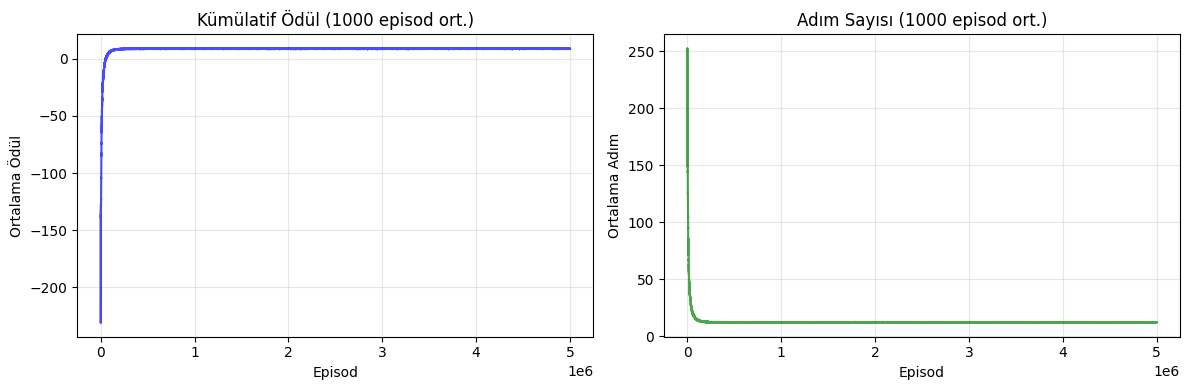

In [40]:
import random
import time

state_size = get_state_size()
action_size = env.action_space.n
q_table = np.zeros([state_size, action_size])

alpha, gamma, epsilon = 0.1, 1.0, 0.1
num_episodes = 5_000_000
eval_every = 50_000

cum_rewards = []
total_epochs = []
best_reward = -np.inf
best_q_table = None

print(f"Q-Table boyutu: {q_table.shape}")
print(f"Toplam state: {state_size:,}")
print(f"Eğitim başlıyor... {num_episodes:,} episod")


start_time = time.time()

for episode in range(1, num_episodes + 1):
    state_dict, info = env.reset()
    state = state_to_index(state_dict)
    action_mask = info['action_mask']
    terminated = False
    epoch = 0
    cum_reward = 0

    while not terminated:

        valid_actions = np.where(action_mask == 1)[0]


        if len(valid_actions) == 0:
             break

        if random.uniform(0, 1) < epsilon:
            action = np.random.choice(valid_actions)
        else:
            q_vals = q_table[state].copy()
            q_vals[action_mask == 0] = -np.inf
            action = np.argmax(q_vals)

        next_state_dict, reward, terminated, _, info = env.step(action)
        next_state = state_to_index(next_state_dict)
        next_action_mask = info['action_mask']
        cum_reward += reward
        epoch += 1


        old_q = q_table[state, action]
        next_max = np.max(q_table[next_state]) if not terminated else 0
        q_table[state, action] = (1 - alpha) * old_q + alpha * (reward + gamma * next_max)

        state = next_state
        action_mask = next_action_mask

    cum_rewards.append(cum_reward)
    total_epochs.append(epoch)


    if episode % eval_every == 0:
        avg_reward = np.mean(cum_rewards[-eval_every:])
        avg_steps = np.mean(total_epochs[-eval_every:])


        current_time = time.time()
        elapsed_seconds = current_time - start_time
        hours = int(elapsed_seconds // 3600)
        minutes = int((elapsed_seconds % 3600) // 60)
        seconds = int(elapsed_seconds % 60)

        time_str = f"{hours}sa {minutes}dk {seconds}sn"

        print(f"Episod {episode:,}: Ø Ödül = {avg_reward:.2f} | Ø Adım = {avg_steps:.1f} | Süre: {time_str}")

        if avg_reward > best_reward:
            best_reward = avg_reward
            best_q_table = q_table.copy()
            np.save("best_q_table.npy", best_q_table)
            print(f"   ⭐ YENİ EN İYİ! (Ø Ödül: {best_reward:.2f})")

# Toplam süre sonu
end_time = time.time()
total_seconds = end_time - start_time
total_time_str = f"{int(total_seconds // 3600)}sa {int((total_seconds % 3600) // 60)}dk {int(total_seconds % 60)}sn"

print(f"\n✅ Eğitim tamamlandı! Toplam Süre: {total_time_str}")
print(f"En iyi model kaydedildi: best_q_table.npy")

# Grafikler
window = 1000
cum_rewards_smoothed = [np.mean(cum_rewards[max(0,i-window):i+1]) for i in range(len(cum_rewards))]
total_epochs_smoothed = [np.mean(total_epochs[max(0,i-window):i+1]) for i in range(len(total_epochs))]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cum_rewards_smoothed, color='blue', alpha=0.7)
plt.title("Kümülatif Ödül (1000 episod ort.)")
plt.xlabel("Episod")
plt.ylabel("Ortalama Ödül")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(total_epochs_smoothed, color='green', alpha=0.7)
plt.title("Adım Sayısı (1000 episod ort.)")
plt.xlabel("Episod")
plt.ylabel("Ortalama Adım")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

np.save("final_q_table.npy", q_table)

In [43]:
import imageio
from IPython.display import HTML, display

def store_episode_as_gif(experience_buffer, filename="animation_random.gif"):
    frames = [exp['frame'] for exp in experience_buffer]
    imageio.mimsave(filename, frames, fps=4)
    print(f"GIF kaydedildi: {filename}")

def run_animation(experience_buffer):
    frames = [exp['frame'] for exp in experience_buffer]
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    im = plt.imshow(frames[0])

    def update(i):
        im.set_array(frames[i])
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=250, repeat=True)
    plt.close(fig)
    return HTML(anim.to_jshtml())

print("Eğitimli politika FARKLI SENARYOLARDA test ediliyor...")

num_episodes = 3
experience_buffer = []

for episode in range(1, num_episodes + 1):
    state_dict, info = env.reset()

    state = state_to_index(state_dict)
    terminated = False
    cum_reward = 0

    print(f"Episod {episode} başlıyor...")

    experience_buffer.append({
        'frame': env.render(),
        'episode': episode,
        'state': state
    })

    while not terminated:
        action_mask = info['action_mask']
        q_vals = q_table[state].copy()
        q_vals[action_mask == 0] = -np.inf
        action = np.argmax(q_vals)

        next_state_dict, reward, terminated, truncated, info = env.step(action)
        next_state = state_to_index(next_state_dict)
        cum_reward += reward


        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'state': next_state
        })

        state = next_state

    print(f"Episod {episode} tamamlandı. Toplam Ödül: {cum_reward}")


store_episode_as_gif(experience_buffer, "animation_random.gif")

print("\nAnimasyon oynatılıyor (Tüm episodlar peş peşe)...")
display(run_animation(experience_buffer))

Eğitimli politika FARKLI SENARYOLARDA test ediliyor...
Episod 1 başlıyor...
Episod 1 tamamlandı. Toplam Ödül: 8
Episod 2 başlıyor...
Episod 2 tamamlandı. Toplam Ödül: 12
Episod 3 başlıyor...
Episod 3 tamamlandı. Toplam Ödül: 8
GIF kaydedildi: animation_random.gif

Animasyon oynatılıyor (Tüm episodlar peş peşe)...
